In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil

PATH_1 = '/content/drive/MyDrive/cleandatasets/test_dataset.parquet'
PATH_2 = '/content/drive/MyDrive/cleandatasets/train_dataset.parquet'
shutil.copy(PATH_1, '/content/')
shutil.copy(PATH_2, '/content/')

'/content/train_dataset.parquet'

In [5]:
# get and concat train and test data

dataset_dir = 'test_dataset.parquet'

df1 = pd.read_parquet(dataset_dir)

dataset_dir = 'train_dataset.parquet'

df2 = pd.read_parquet(dataset_dir)

df = pd.concat([df2, df1])

df.loc[df["passenger_count"] == 0, "passenger_count"] = 1

FREQ = '3H'

# We want to calculate demand (based on this formula) for each 3 hour time interval in each LocationID.
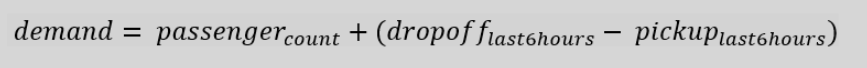

In [6]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

df.sort_values('tpep_pickup_datetime', inplace=True)
df = df[df['tpep_pickup_datetime'] > '2023']

def number_of_pickups_in6hour(df):
    pickups_6h = df.set_index(df['tpep_pickup_datetime'])
    # Resample the DataFrame to 6-hour intervals and count the number of pickups
    pickups_6h = pickups_6h.groupby([pd.Grouper(freq='6H'), 'PULocationID']).count()

    return pickups_6h


def number_of_dropoffs_in6hour(df):
    dropoffs_6h = df.set_index(df['tpep_dropoff_datetime'])
    # Resample the DataFrame to 6-hour intervals and count the number of drop-offs
    dropoffs_6h = dropoffs_6h.groupby([pd.Grouper(freq='6H'), 'DOLocationID']).count()

    return dropoffs_6h

pickups_6h_df = number_of_pickups_in6hour(df).reset_index(level=['PULocationID'])
dropoffs_6h_df = number_of_dropoffs_in6hour(df).reset_index(level=['DOLocationID'])



df.set_index(df['tpep_pickup_datetime'], inplace=True)
df.dropna(axis=0, inplace=True)

def demand_calculation(x):
  passenger_sum = x['passenger_count'].sum()

  demand = passenger_sum + 1

  if len(x['tpep_pickup_datetime']) != 0:
    first_time = x['tpep_pickup_datetime'].iloc[0]
    location = x['PULocationID'].iloc[0]
    pickups_6h_def_filtered = pickups_6h_df.loc[(pickups_6h_df.index < first_time) & (pickups_6h_df['PULocationID'] == location)]
    dropoffs_6h_df_filtered = dropoffs_6h_df.loc[(dropoffs_6h_df.index < first_time) & (dropoffs_6h_df['DOLocationID'] == location)]


    if len(pickups_6h_def_filtered) > 0 and len(dropoffs_6h_df_filtered) > 0:
        diff = dropoffs_6h_df_filtered.iloc[-1]['tpep_pickup_datetime'] - pickups_6h_def_filtered.iloc[-1]['tpep_dropoff_datetime']

        if diff > 0 :
            return demand + diff

  return demand



df_t = df.groupby([pd.Grouper(freq=FREQ), 'PULocationID']).apply(demand_calculation)
df_t = df_t.to_frame(name='demand').reset_index(level=['PULocationID'])

In [7]:
df_new = df_t.copy()
df_new = df_new.reset_index()
df_new = df_new.rename(columns = {'tpep_pickup_datetime':'timestamp'})

df_new['timestamp'] = pd.to_datetime(df_new['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_new = df_new.loc[df_new['timestamp'] < '2023-05-01']

df_new[df_new.timestamp=='2023-01-01 00:00:00']

,timestamp,PULocationID,demand
0,2023-01-01,4,186.0
1,2023-01-01,7,290.0
2,2023-01-01,10,18.0
3,2023-01-01,12,6.0
4,2023-01-01,13,141.0
...,...,...,...
148,2023-01-01,261,143.0
149,2023-01-01,262,584.0
150,2023-01-01,263,932.0
151,2023-01-01,264,285.0


### Add demand 0 for each time interval and LocationID that didn't exist.

In [8]:
df_grouped = df_new.groupby("timestamp")
group_keys = list(df_grouped.groups.keys())
po_loc_ids = np.arange(1, 264)

for i in group_keys:
    df1 = df_grouped.get_group(i)

    current_pu_loc = df1["PULocationID"].to_numpy()

    ids_not_in_po_loc = np.setdiff1d(po_loc_ids , current_pu_loc).tolist()

    demand = []

    for id in ids_not_in_po_loc:

        pickups_6h_def_filtered = pickups_6h_df.loc[(pickups_6h_df.index  < df1['timestamp'].iloc[0]) & (pickups_6h_df.PULocationID == id)]
        dropoffs_6h_df_filtered = dropoffs_6h_df.loc[(dropoffs_6h_df.index  < df1['timestamp'].iloc[0]) & (dropoffs_6h_df.DOLocationID == id)]

        if len(pickups_6h_def_filtered) > 0 and len(dropoffs_6h_df_filtered) > 0:
            diff = dropoffs_6h_df_filtered.iloc[-1]['tpep_pickup_datetime'] - pickups_6h_def_filtered.iloc[-1]['tpep_dropoff_datetime']

            if diff > 0 :
                demand.append(diff + 1)
            else:
                demand.append(1)

        else:
            demand.append(1)

    n = len(ids_not_in_po_loc)

    new_data = {'timestamp': [df1['timestamp'].iloc[0]] * n, 'PULocationID': ids_not_in_po_loc, 'demand': demand}

    new_rows_df = pd.DataFrame(new_data)

    df_new = pd.concat([df_new, new_rows_df], ignore_index=True)

df_new

,timestamp,PULocationID,demand
0,2023-01-01 00:00:00,4,186.0
1,2023-01-01 00:00:00,7,290.0
2,2023-01-01 00:00:00,10,18.0
3,2023-01-01 00:00:00,12,6.0
4,2023-01-01 00:00:00,13,141.0
...,...,...,...
254386,2023-04-30 21:00:00,253,1.0
254387,2023-04-30 21:00:00,254,1.0
254388,2023-04-30 21:00:00,257,11.0
254389,2023-04-30 21:00:00,258,7.0


In [9]:
dir_path = 'org_demand_pu_3h.parquet'
df_new.to_parquet(dir_path)

In [10]:
shutil.copy('/content/'+ dir_path,'/content/drive/MyDrive/Demand/')

'/content/drive/MyDrive/Demand/org_demand_pu_3h.parquet'